# Manoeuvring parameter identification

Can the method that was introduced in the [Ball drop example](00.01_intro.ipynb#Example) be applied to a more complex system? This will be attempted in this chapter based on the results from the manoeuvring simulation from the [previous chapter](01.01_manoeuvring_simulation.ipynb#Simulate-data).

In [1]:
# %load imports.py
## Local packages:

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns

import matplotlib.pyplot as plt
if os.name == 'nt':
    plt.style.use('book.mplstyle')  # Windows

import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex, Markdown
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl

from src.symbols import *
from src.parameters import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.regression import show_pred
from src.visualization.plot import track_plot
from src.visualization.equation import Equation
from myst_nb import glue

## Load models:
# (Uncomment these for faster loading):
import src.models.vmm_nonlinear_EOM  as vmm 
    
## Examples
from example_1 import ship_parameters, df_parameters, ps, ship_parameters_prime

## Decoupling
The hydrodynamic derivatives in a mathematical model for ship manoeuvring should be identified by expressing the ODE as a OLS regression. There is a coupling between the sway and yaw equation in this model. These equations need to be decoupled {cite:p}`wang_parameter_2021`, in a similar way as how it was done in the previous chapter. The simulation model can be expressed as:

In [2]:
A = vmm.simulator.A
b = vmm.simulator.b
acceleration = sp.matrices.MutableDenseMatrix([u1d,v1d,r1d])
eq_simulator = sp.Eq(sp.UnevaluatedExpr(A)*sp.UnevaluatedExpr(acceleration),sp.UnevaluatedExpr(b))
Math(vlatex(eq_simulator))

<IPython.core.display.Math object>

$X_{qs}$, $Y_{qs}$, $N_{qs}$ are the quasi static hydrodynamic force models, that contains the hydrodynamic derivatives ($Y_{uv}$ etc.) that should be identified.

The PIT should be expressed as three regressions based on $\dot{u}$, $\dot{v}$ and $\dot{r}$:

In [3]:
coeff_matrix = sp.matrices.MutableDenseMatrix([A_coeff*X_X,B_coeff*X_Y,C_coeff*X_N])
eq_regression = sp.Eq(acceleration, coeff_matrix)
Math(vlatex(eq_regression))

<IPython.core.display.Math object>

Where $A_{coeff}$, $B_{coeff}$ and $C_{coeff}$ are coefficient vectors from where the hydrodynamic derivatives can be obtained with decoupling as follows, where eq.{eq}`eq_coeff` has been inserted into eq.{eq}`eq_simulator`:

In [4]:
Math(vlatex(sp.Eq(sp.UnevaluatedExpr(A)*sp.UnevaluatedExpr(coeff_matrix),sp.UnevaluatedExpr(b))))

<IPython.core.display.Math object>

```{glue:math} sym_eq
:label: eq_simulator_coeff
```

And the right hand side of this equation can also be expressed with vectors:

In [5]:
X_qs_, Y_qs_, N_qs_ = sp.symbols('X_qs, Y_qs, N_qs')
eq_X_qs = sp.Eq(X_qs_*X_X, b[0])
Math(vlatex(eq_X_qs))

<IPython.core.display.Math object>

In [6]:
eq_Y_qs = sp.Eq(X_qs_*X_Y, b[1])
Math(vlatex(eq_Y_qs))

<IPython.core.display.Math object>

In [7]:
eq_N_qs = sp.Eq(N_qs_*X_N, b[2])
Math(vlatex(eq_N_qs))

<IPython.core.display.Math object>

So that the parameter vectors $X_{qs}$, $Y_{qs}$, $N_{qs}$ can be calculated from $A_{coeff}$, $B_{coeff}$ and $C_{coeff}$ in the following way.

In [8]:
Math(vlatex(sp.Eq(sp.UnevaluatedExpr(A)*sp.UnevaluatedExpr(sp.matrices.MutableDenseMatrix([A_coeff,B_coeff,C_coeff])),
                  sp.UnevaluatedExpr(sp.matrices.MutableDenseMatrix([X_qs_,Y_qs_,N_qs_])))))

<IPython.core.display.Math object>

## Regression
The parameter vectors : $A_{coeff}$, $B_{coeff}$ and $C_{coeff}$ are determined with OLS regression:

### Load simulation results:

In [9]:
df_result = pd.read_csv('first_simulation.csv', index_col=0)  # (gnereated by:01.01_manoeuvring_simulation.ipynb)
df = ps.prime(df_result, U=df_result['U'])

### N

In [11]:
N_ = sp.symbols('N_')

diff_eq_N = regression.DiffEqToMatrix(ode=vmm.N_qs_eq.subs(N_D,N_), 
                                      label=N_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    r1d   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.245e+26
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:08:10   Log-Likelihood:             2.8889e+05
No. Observations:               10000   AIC:                        -5.778e+05
Df Residuals:                    9995   BIC:                        -5.777e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Nur            0.0801   9.26e-12   8.65e+09      0.000       0.080       0.080
Ndelta        -0.6956    2.2e-11  -3.17e+10      0.000      -0.696      -0.696
Nr            -2.3773   9.01e-12  -2.64e+11      0.000      -2.377      -2.377
Nu          -3.34e-13   7.67e-12     -0.044      0.965   -1.54e-11    1.47e-11
Nv            -4.2146      1e-12  -4.21e+12      0.000      -4.215      -4.215
==============================================================================
Omnibus:                      347.998   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.582
Skew:                          -0.101   Prob(JB):                     1.50e-37
Kurtosis:                       2.395   Cond. No.                     4.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

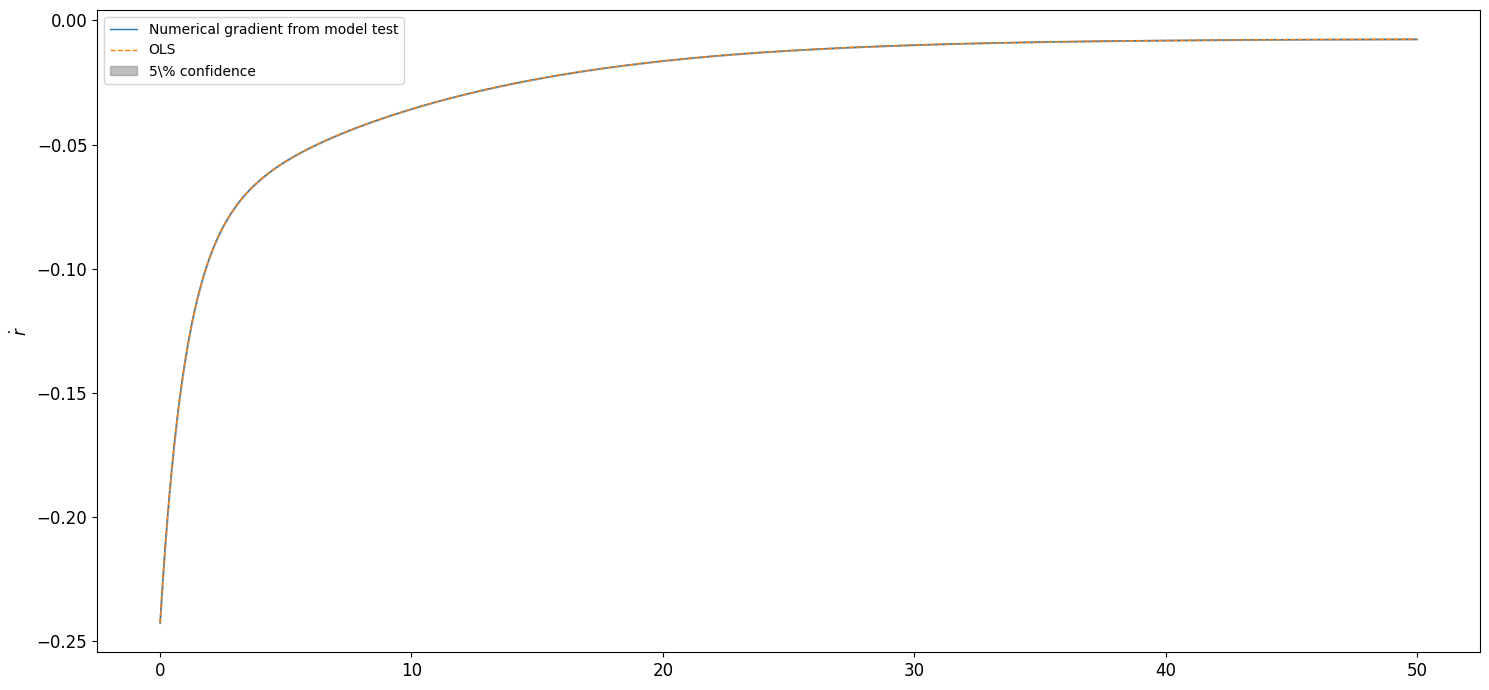

In [12]:
X = diff_eq_N.calculate_features(data=df)
y = diff_eq_N.calculate_label(y=df['r1d'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$\dot{r}$')

### Y

In [13]:
Y_ = sp.symbols('Y_')
diff_eq_Y = regression.DiffEqToMatrix(ode=vmm.Y_qs_eq.subs(Y_D,Y_), 
                                      label=Y_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    v1d   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.490e+26
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:08:18   Log-Likelihood:             2.9732e+05
No. Observations:               10000   AIC:                        -5.946e+05
Df Residuals:                    9995   BIC:                        -5.946e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yur           -0.4593   3.98e-12  -1.15e+11      0.000      -0.459      -0.459
Ydelta         0.0924   9.45e-12   9.78e+09      0.000       0.092       0.092
Yr             0.2383   3.88e-12   6.15e+10      0.000       0.238       0.238
Yu          1.248e-13    3.3e-12      0.038      0.970   -6.34e-12    6.59e-12
Yv            -0.6437   4.31e-13  -1.49e+12      0.000      -0.644      -0.644
==============================================================================
Omnibus:                     2949.712   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6737.720
Skew:                          -1.708   Prob(JB):                         0.00
Kurtosis:                       5.121   Cond. No.                     4.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

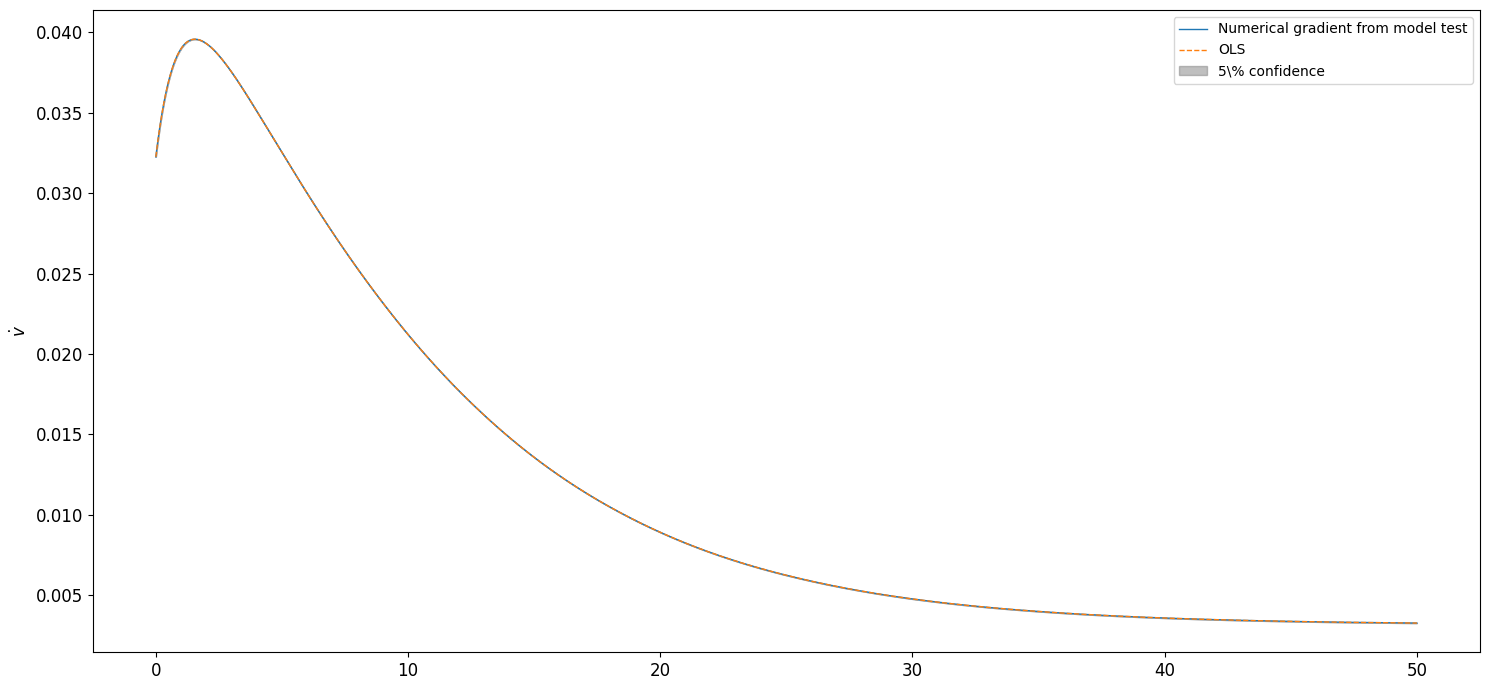

In [14]:
X = diff_eq_Y.calculate_features(data=df)
y = diff_eq_Y.calculate_label(y=df['v1d'])


model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$\dot{v}$')

### X

In [15]:
X_ = sp.symbols('X_')
diff_eq_X = regression.DiffEqToMatrix(ode=vmm.X_qs_eq.subs(X_D,X_), 
                                      label=X_, base_features=[delta,u,v,r,thrust])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    u1d   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.211e+23
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:08:29   Log-Likelihood:             2.4405e+05
No. Observations:               10000   AIC:                        -4.881e+05
Df Residuals:                    9994   BIC:                        -4.880e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xrr            1.0269   1.55e-09    6.6e+08      0.000       1.027       1.027
Xvr            0.1460   1.77e-08   8.24e+06      0.000       0.146       0.146
Xdelta        -0.1467   1.63e-07  -8.99e+05      0.000      -0.147      -0.147
Xr         -1.741e-13   2.23e-10     -0.001      0.999   -4.38e-10    4.37e-10
Xu            -0.1467    5.7e-08  -2.58e+06      0.000      -0.147      -0.147
Xv         -1.307e-12   1.42e-09     -0.001      0.999   -2.79e-09    2.78e-09
==============================================================================
Omnibus:                     1467.412   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2231.719
Skew:                          -1.157   Prob(JB):                         0.00
Kurtosis:                       3.010   Cond. No.                     3.26e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

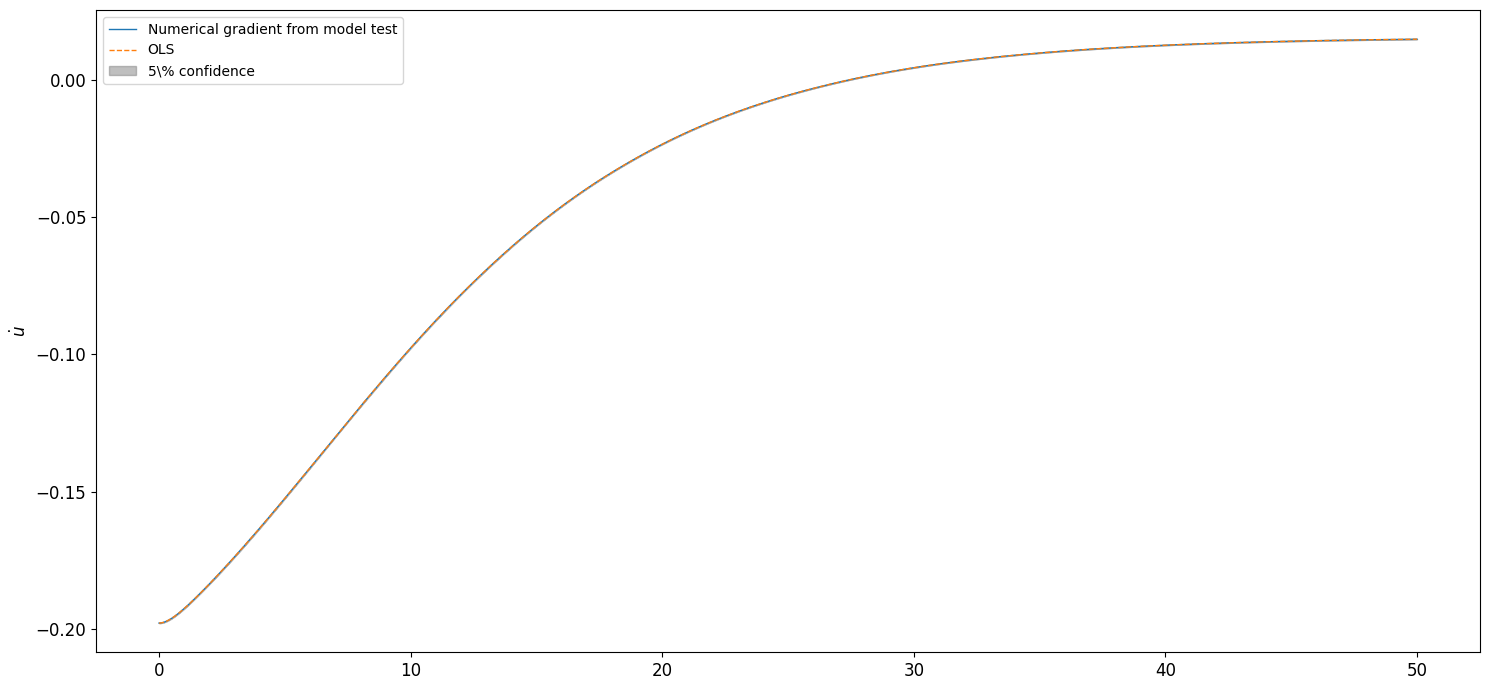

In [16]:
X = diff_eq_X.calculate_features(data=df)
y = diff_eq_X.calculate_label(y=df['u1d'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$\dot{u}}$')

### Decoupling

In [17]:
subs = {value:key for key,value in p.items()}
A_ = A*sp.matrices.MutableDenseMatrix([A_coeff,B_coeff,C_coeff])
A_lambda=lambdify(A_.subs(subs))

In [18]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

A_coeff_ = results_summary_X['coeff']
B_coeff_ = results_summary_Y['coeff']
C_coeff_ = results_summary_N['coeff']

coeffs = run(A_lambda,A_coeff=A_coeff_.values, B_coeff=B_coeff_.values, C_coeff=C_coeff_.values, 
    **df_parameters['prime'], **ship_parameters_prime)

<lambdifygenerated-32>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (array([[A_coeff*(-Xudot + m)], [B_coeff*(-Yvdot + m) + C_coeff*(-Yrdot + m*x_G)], [B_coeff*(-Nvdot + m*x_G) + C_coeff*(I_z - Nrdot)]]))


The way that the regression is formulated, inertial forces, such as centrifugal force will be included into the derivatives (I think) which means that centrifugal force : $-m \cdot r \cdot u$ will be included into $Y_{ur}$ coefficient. This coefficient is therefore not pure hydrodynamic, and can potentially be counted twice..?
The coefficients are recalculated below to avooid this:

In [19]:
results_summary_X['decoupled'] = coeffs[0][0]
results_summary_Y['decoupled'] = coeffs[1][0]
results_summary_N['decoupled'] = coeffs[2][0]

x_G_ = ship_parameters_prime['x_G']
m_ = ship_parameters_prime['m']

results_summary_X.loc['Xrr','decoupled']+=(-m_*x_G_)
results_summary_X.loc['Xvr','decoupled']+=(-m_)
results_summary_Y.loc['Yur','decoupled']+=m_
results_summary_N.loc['Nur','decoupled']+=m_*x_G_

### Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [20]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'decoupled':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['regressed'] = df_parameters_all['regressed'].combine_first(df_parameters_all['prime'])  # prefer regressed
#df_parameters_all['regressed'].fillna(0,inplace=True)

# Simulation

A simulation with the regressed hydrodynamic coefficients can now be conducted. The figures below compare results from these simulation and the original data.

In [21]:
parameters=df_parameters_all['regressed'].copy()

result_regression = vmm.simulator.simulate(df_=df_result, 
                                           parameters=parameters, 
                                           ship_parameters=ship_parameters, 
                                           control_keys=['delta'], 
                                           primed_parameters=True,
                                           prime_system=ps,
                                           name='regressed')

result_regression.df_model_test=df_result  # dirty

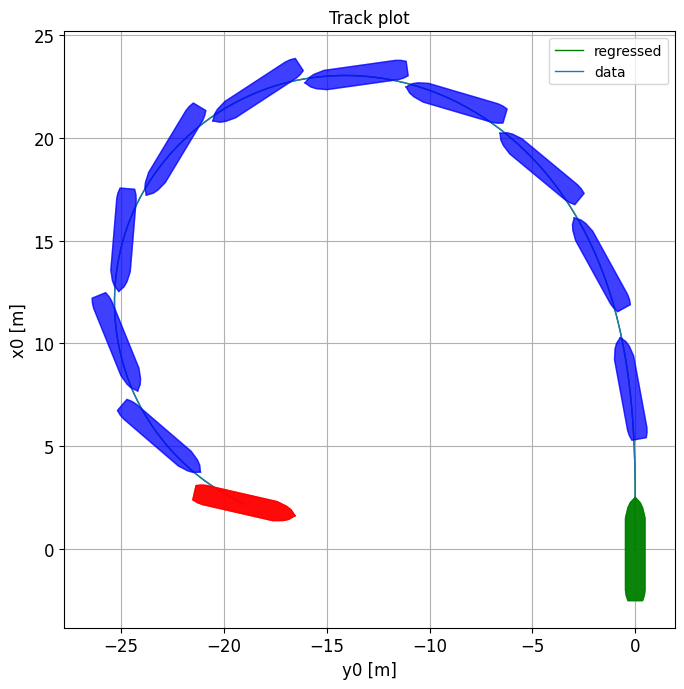

In [22]:
result_regression.track_plot(compare=True);

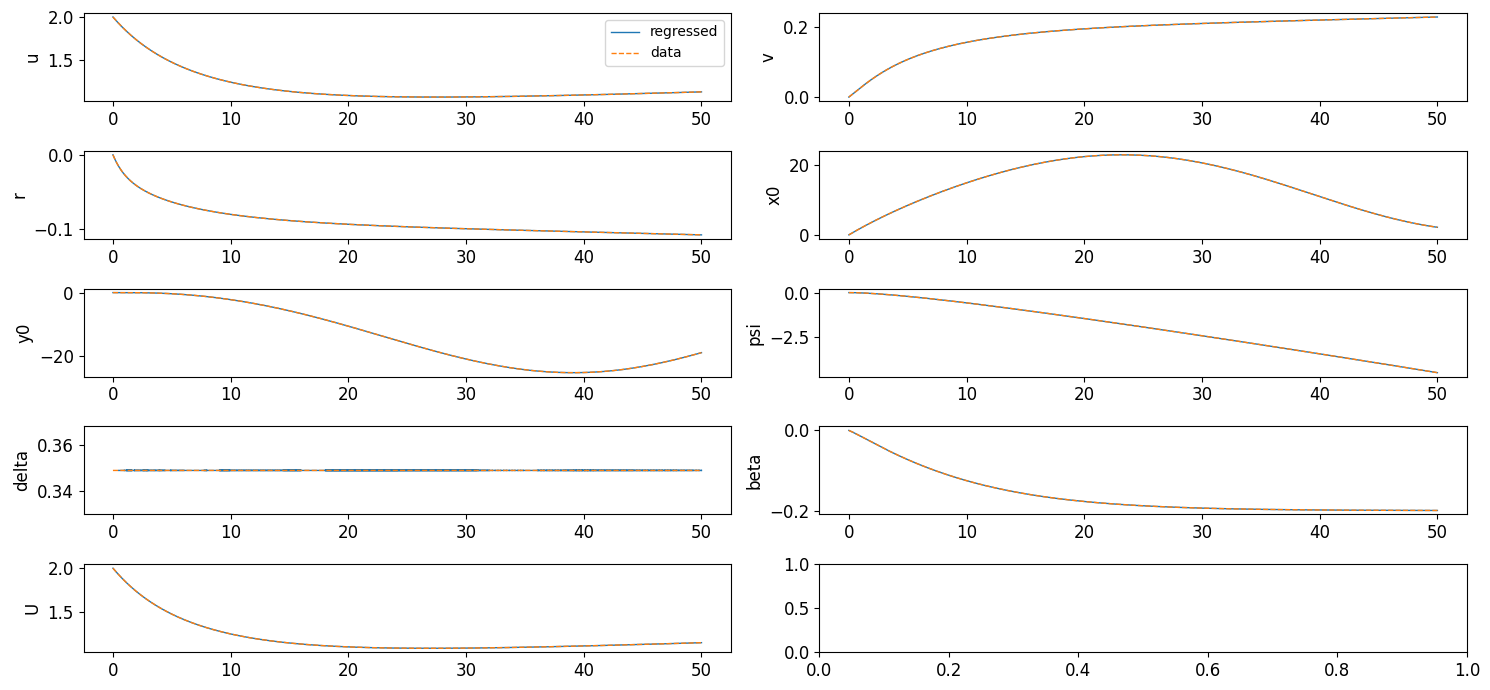

In [23]:
result_regression.plot(compare=True);

And the regressed hydrodynamic derivatives can be compared with the original parameters, refered to as "prime" in the bar chart below:

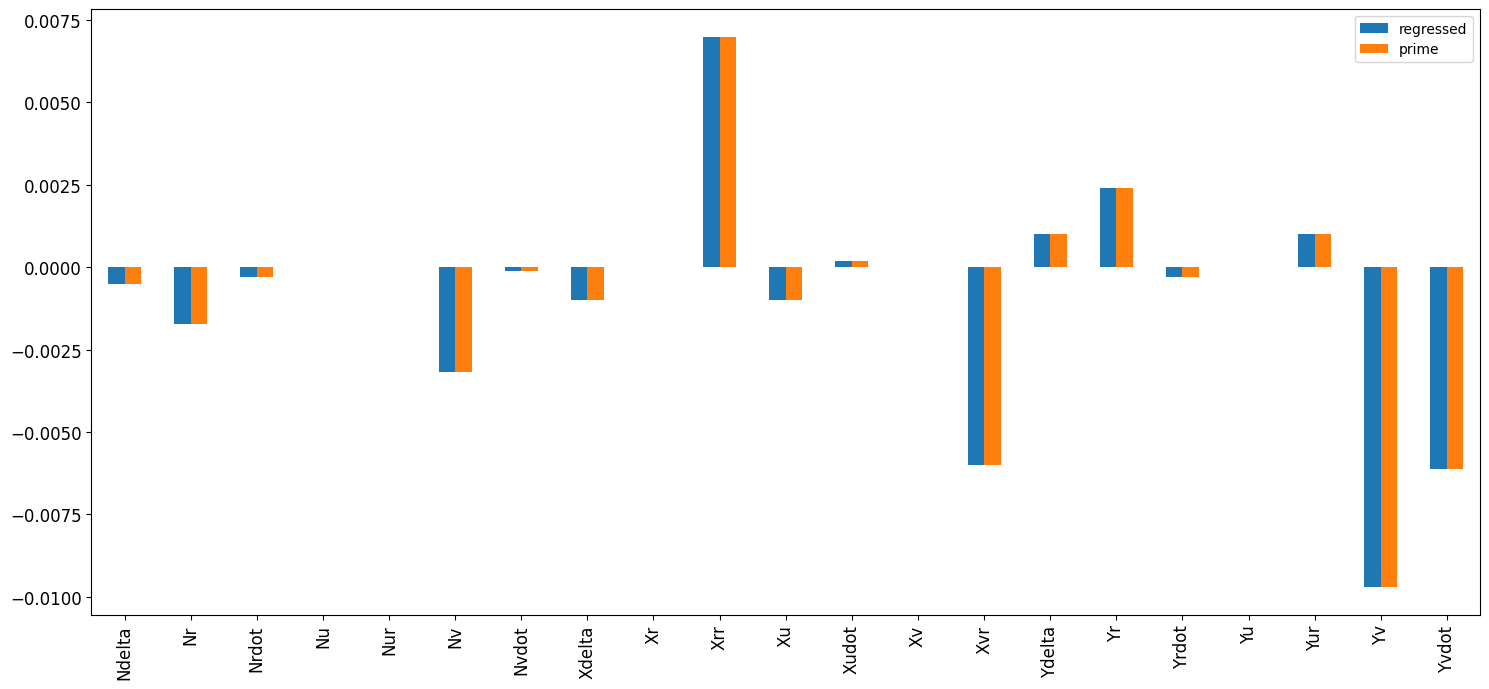

In [24]:
df_plot_parameters = df_parameters_all[['regressed','prime']].copy()
mask = ((df_plot_parameters['regressed'].abs() > 0) &
        (df_plot_parameters['regressed'].abs() < 0.99) 
       )

df_plot_parameters.loc[mask].plot(kind='bar')

mask = (
        (df_plot_parameters['regressed'].abs() > 0.99) 
       )
if mask.any():
    df_plot_parameters.loc[mask].plot(kind='bar')

## Measurement noise
The regression seems to be able to identify the parameters in the model if it is given perfect data, but what will happen if the data has some measurement or process noise? A new regression with gausian noise added to the data will be conducted to investigate this.

In [25]:
df_measure = df_result.copy()

scales = df_measure.max()-df_measure.min()
noise = np.random.normal(scale=0.04*scales, size=df_measure.shape)
df_noise = pd.DataFrame(data=noise, columns=df_measure.columns, index=df_measure.index)
df_measure+=df_noise

df = ps.prime(df_measure, U=df_result['U'])

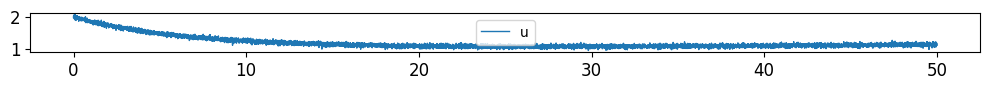

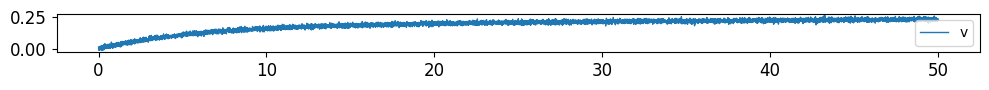

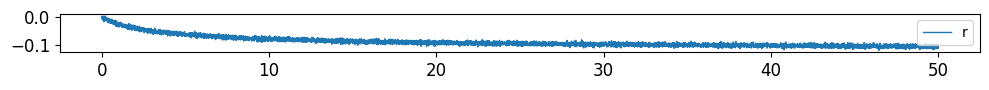

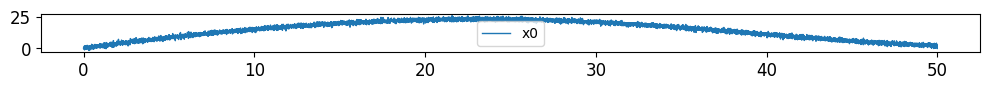

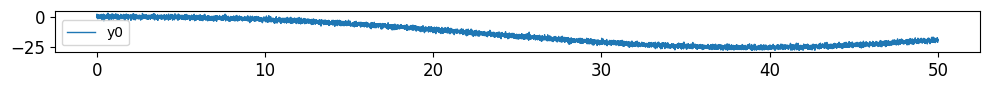

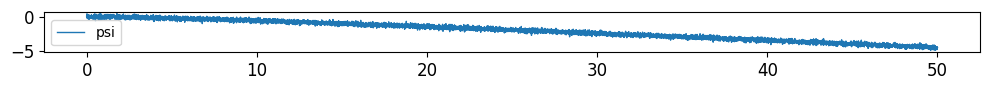

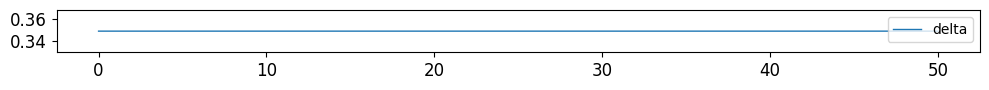

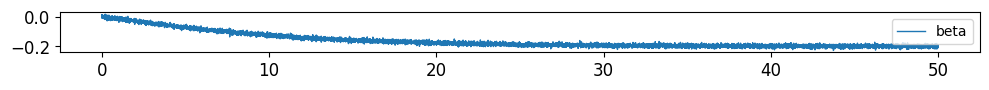

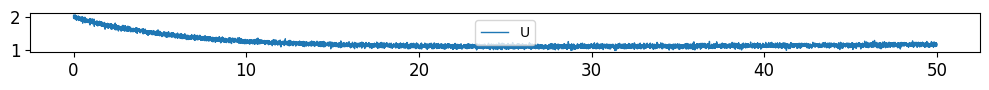

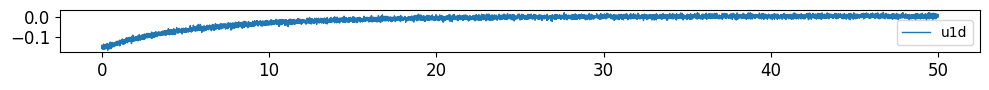

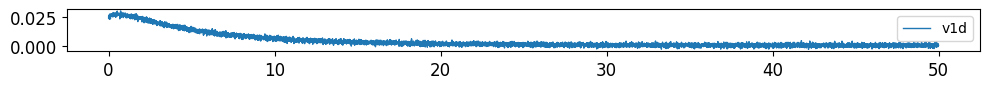

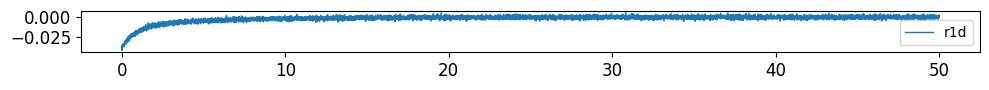

In [26]:
for key in df_measure:
    
    fig,ax=plt.subplots()
    fig.set_size_inches(10,1)
    df_measure.plot(y=key, ax=ax)
    

### N

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    r1d   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     2243.
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:08:41   Log-Likelihood:                 20609.
No. Observations:               10000   AIC:                        -4.121e+04
Df Residuals:                    9995   BIC:                        -4.117e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Nur           -0.4961      0.113     -4.396      0.000      -0.717      -0.275
Ndelta         0.1692      0.136      1.246      0.213      -0.097       0.435
Nr             0.2591      0.113      2.302      0.021       0.038       0.480
Nu            -0.1879      0.048     -3.950      0.000      -0.281      -0.095
Nv             0.0726      0.026      2.796      0.005       0.022       0.124
==============================================================================
Omnibus:                      154.630   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.873
Skew:                          -0.249   Prob(JB):                     3.21e-40
Kurtosis:                       3.435   Cond. No.                         826.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

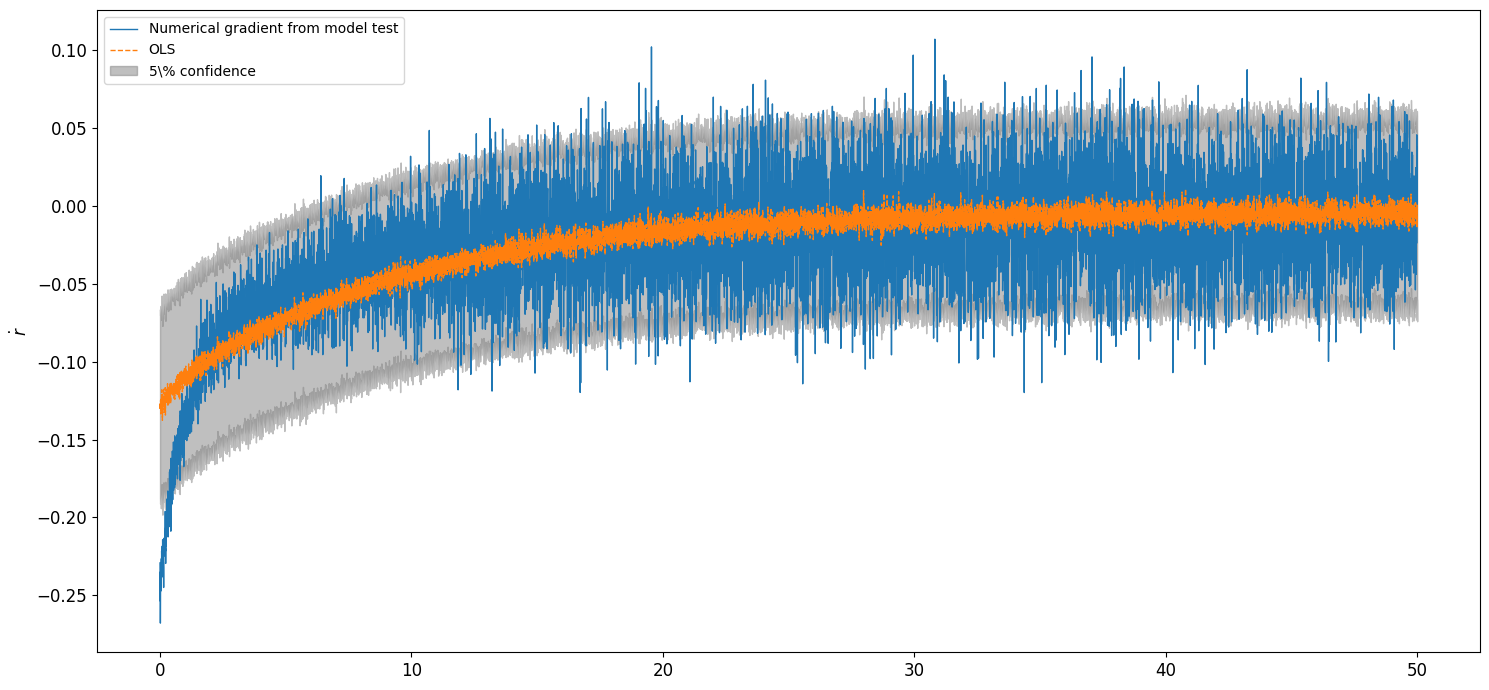

In [27]:
X = diff_eq_N.calculate_features(data=df)
y = diff_eq_N.calculate_label(y=df['r1d'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$\dot{r}$')

## Y

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    v1d   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 1.502e+04
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:08:41   Log-Likelihood:                 40005.
No. Observations:               10000   AIC:                        -8.000e+04
Df Residuals:                    9995   BIC:                        -7.996e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yur           -0.0669      0.016     -4.126      0.000      -0.099      -0.035
Ydelta         0.2055      0.020     10.527      0.000       0.167       0.244
Yr             0.0955      0.016      5.899      0.000       0.064       0.127
Yu            -0.0247      0.007     -3.616      0.000      -0.038      -0.011
Yv            -0.1488      0.004    -39.863      0.000      -0.156      -0.142
==============================================================================
Omnibus:                       77.673   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.034
Skew:                          -0.193   Prob(JB):                     1.54e-18
Kurtosis:                       3.218   Cond. No.                         826.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

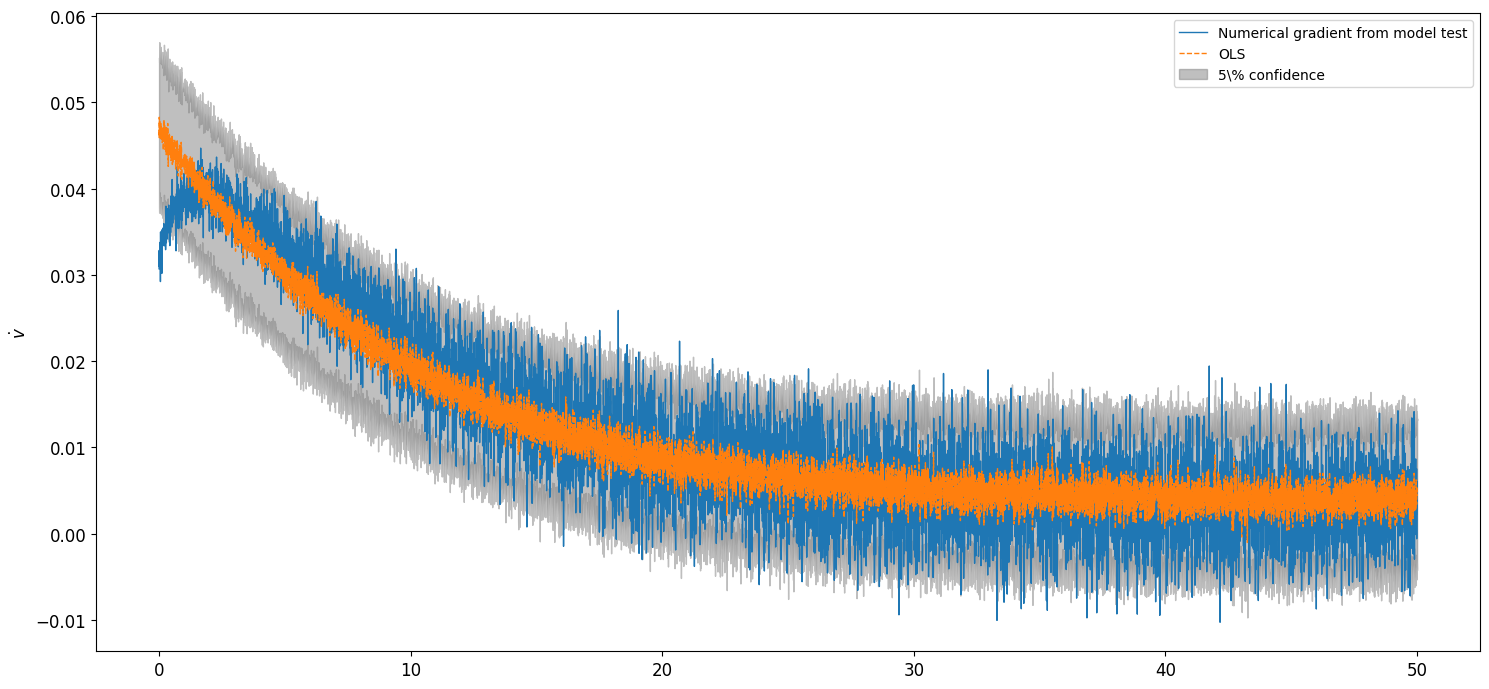

In [28]:
X = diff_eq_Y.calculate_features(data=df)
y = diff_eq_Y.calculate_label(y=df['v1d'])


model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$\dot{v}$')

### X

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    u1d   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 1.236e+04
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:08:42   Log-Likelihood:                 22495.
No. Observations:               10000   AIC:                        -4.498e+04
Df Residuals:                    9994   BIC:                        -4.494e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xrr            0.3349      0.101      3.322      0.001       0.137       0.532
Xvr           -0.7109      0.233     -3.051      0.002      -1.168      -0.254
Xdelta        -0.5387      0.024    -22.633      0.000      -0.585      -0.492
Xr             0.0831      0.045      1.849      0.064      -0.005       0.171
Xu            -0.0118      0.008     -1.471      0.141      -0.028       0.004
Xv             0.5636      0.095      5.955      0.000       0.378       0.749
==============================================================================
Omnibus:                       21.364   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.136
Skew:                           0.023   Prob(JB):                     2.11e-06
Kurtosis:                       3.246   Cond. No.                     1.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

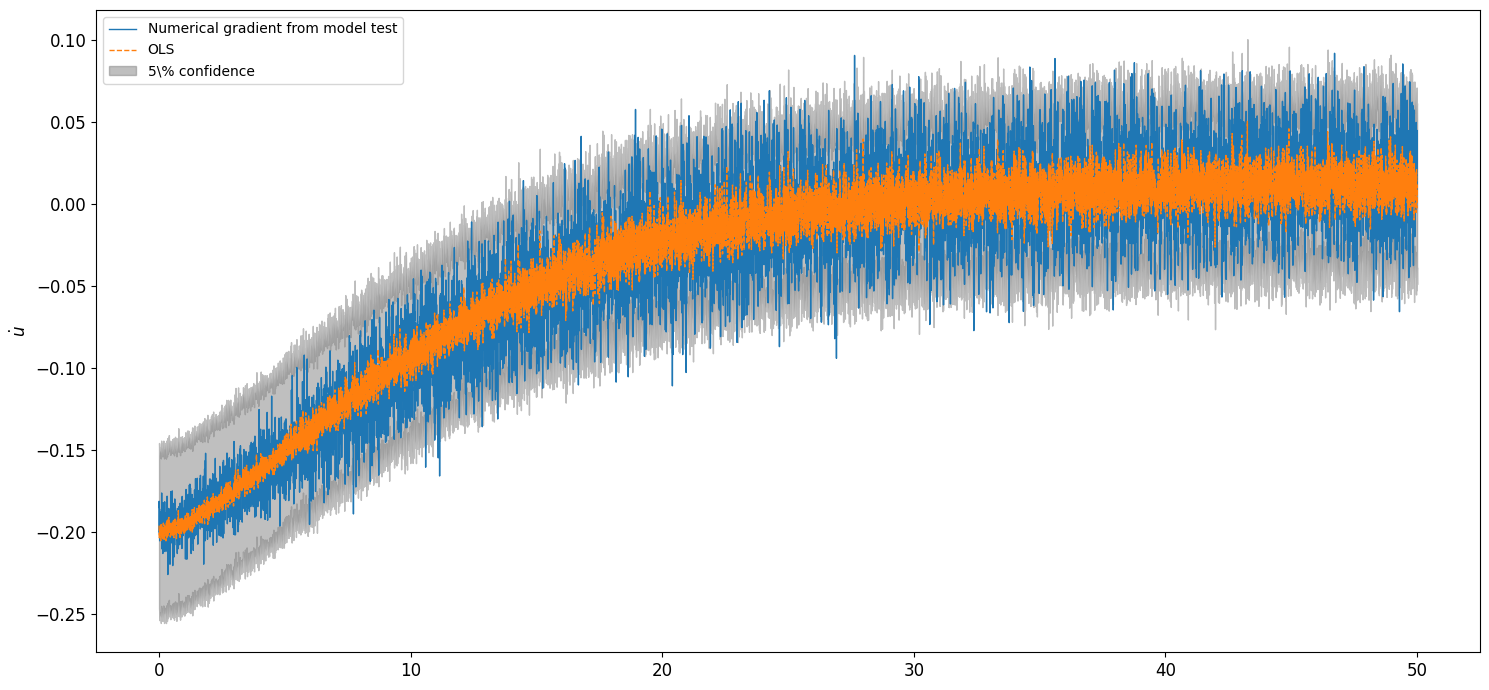

In [29]:
X = diff_eq_X.calculate_features(data=df)
y = diff_eq_X.calculate_label(y=df['u1d'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$\dot{u}}$')

In [30]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

A_coeff_ = results_summary_X['coeff']
B_coeff_ = results_summary_Y['coeff']
C_coeff_ = results_summary_N['coeff']

coeffs = run(A_lambda,A_coeff=A_coeff_.values, B_coeff=B_coeff_.values, C_coeff=C_coeff_.values, 
    **df_parameters['prime'], **ship_parameters_prime)

<lambdifygenerated-32>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (array([[A_coeff*(-Xudot + m)], [B_coeff*(-Yvdot + m) + C_coeff*(-Yrdot + m*x_G)], [B_coeff*(-Nvdot + m*x_G) + C_coeff*(I_z - Nrdot)]]))


In [31]:
results_summary_X['decoupled'] = coeffs[0][0]
results_summary_Y['decoupled'] = coeffs[1][0]
results_summary_N['decoupled'] = coeffs[2][0]

x_G_ = ship_parameters_prime['x_G']
m_ = ship_parameters_prime['m']

results_summary_X.loc['Xrr','decoupled']+=(-m_*x_G_)
results_summary_X.loc['Xvr','decoupled']+=(-m_)
results_summary_Y.loc['Yur','decoupled']+=m_
results_summary_N.loc['Nur','decoupled']+=m_*x_G_

In [32]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'decoupled':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['regressed'] = df_parameters_all['regressed'].combine_first(df_parameters_all['prime'])  # prefer regressed
#df_parameters_all['regressed'].fillna(0,inplace=True)

# Simulation

A simulation with the regressed hydrodynamic coefficients can now be conducted. The figures below compare results from these simulation and the original data.

In [33]:
parameters=df_parameters_all['regressed'].copy()

result_regression = vmm.simulator.simulate(df_=df_result, 
                                           parameters=parameters, 
                                           ship_parameters=ship_parameters, 
                                           control_keys=['delta'], 
                                           primed_parameters=True,
                                           prime_system=ps,
                                           name='regressed')

result_regression.df_model_test=df_result  # dirty

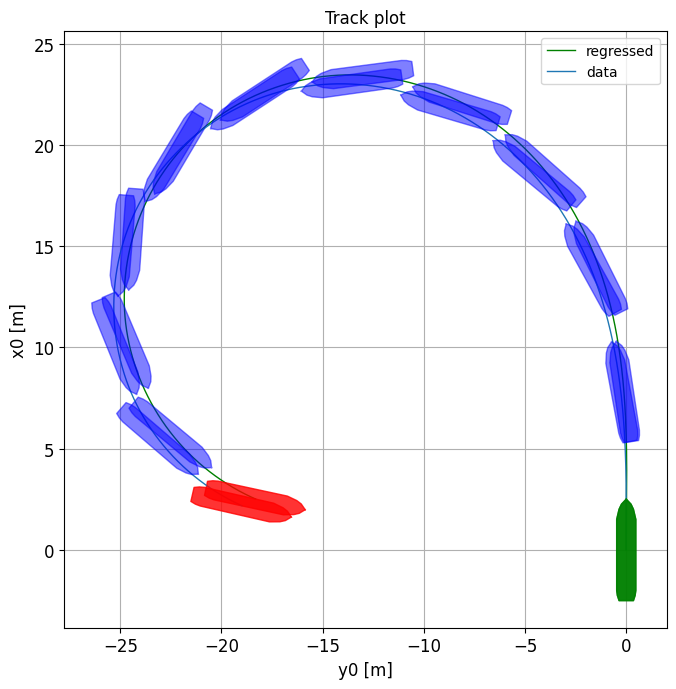

In [34]:
result_regression.track_plot(compare=True);

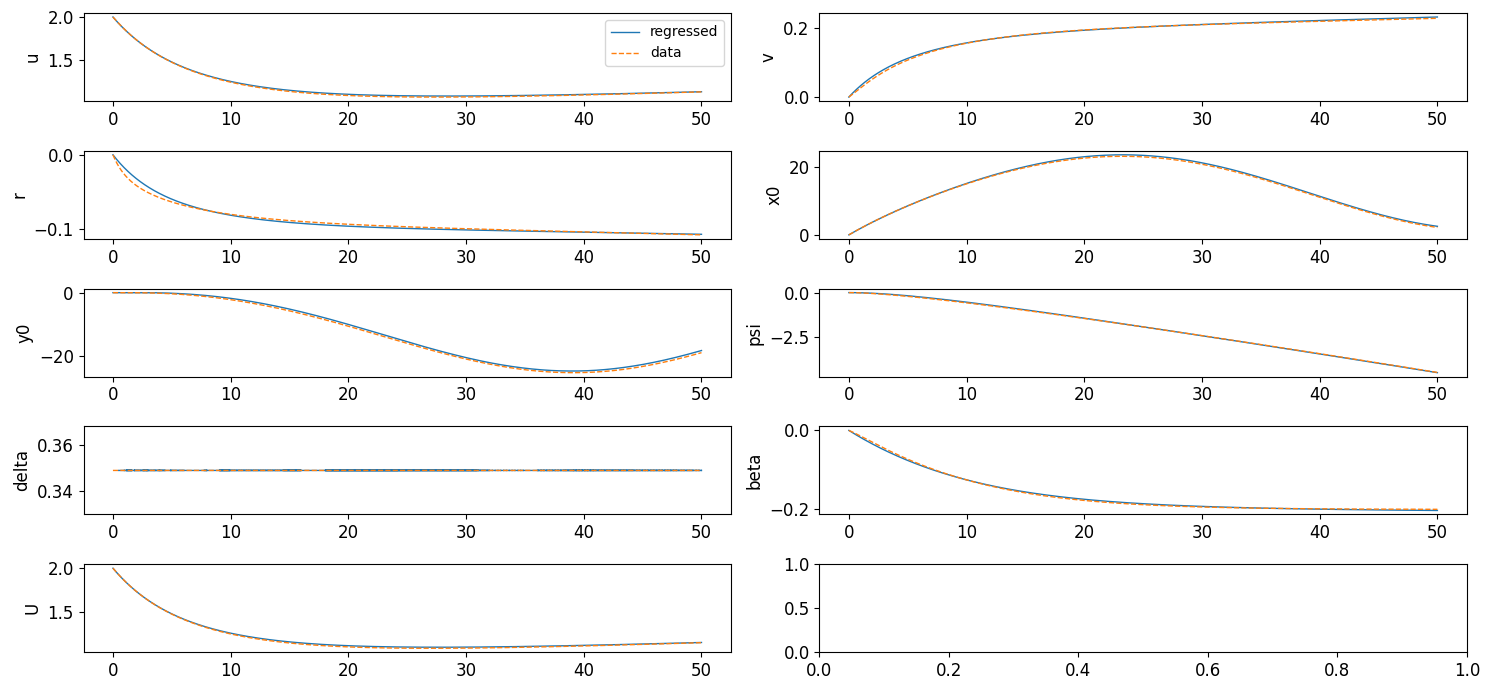

In [35]:
result_regression.plot(compare=True);

And the regressed hydrodynamic derivatives can be compared with the original parameters, refered to as "prime" in the bar chart below:

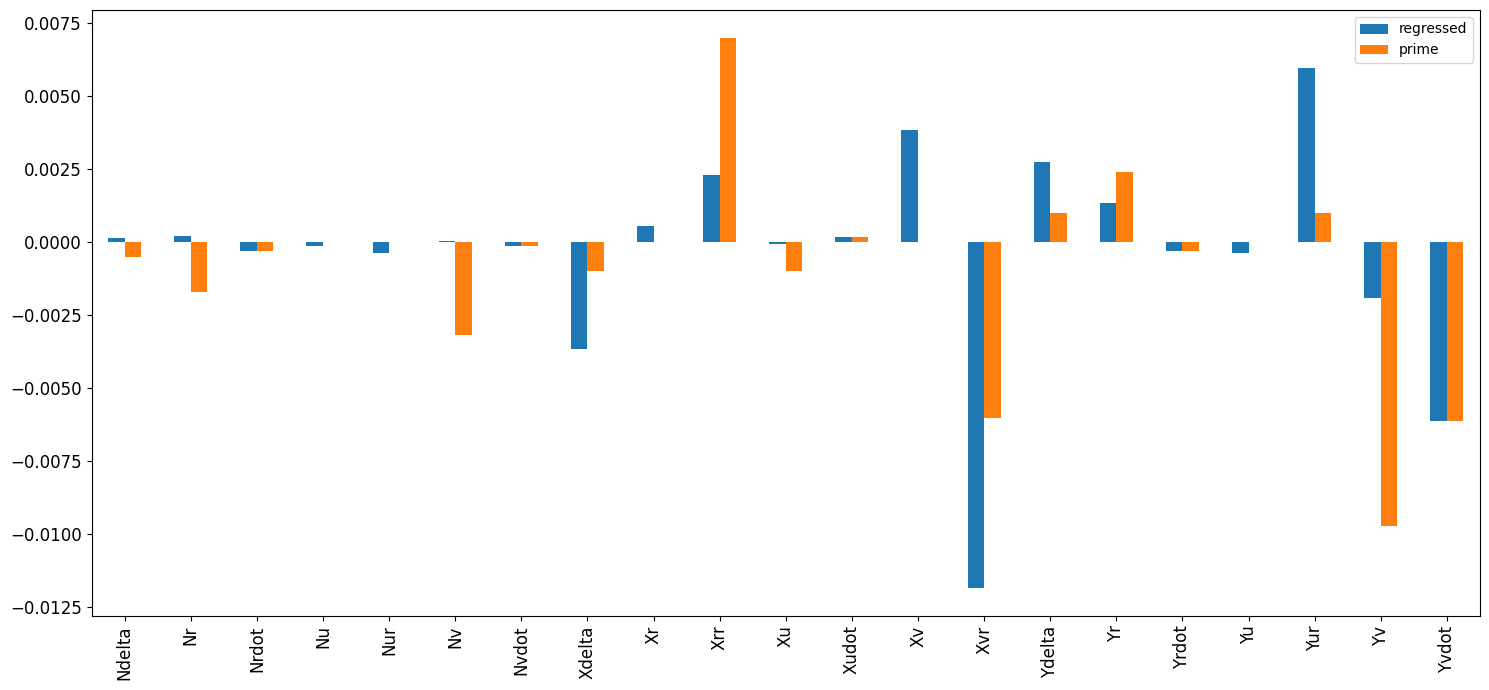

In [36]:
df_plot_parameters = df_parameters_all[['regressed','prime']].copy()
mask = ((df_plot_parameters['regressed'].abs() > 0) &
        (df_plot_parameters['regressed'].abs() < 0.99) 
       )

df_plot_parameters.loc[mask].plot(kind='bar')

mask = (
        (df_plot_parameters['regressed'].abs() > 0.99) 
       )
if mask.any():
    df_plot_parameters.loc[mask].plot(kind='bar')

## Summary
It seams that the hydrodynamic coefficients in a nonlinear manoeuvring simulation model can be identified by regressing the reversed simulation model. The example in this chapter used exact positions, velocities and accelerations, without any measurment error. This is ofcourse an idealized scenario, when using real data from model test or full scale ship, measurement noise will always be present. A gausian noise was added to see if this would cause any problems in the parameter identification. It was found that the regression still identifies a model that recreates the time series pretty accuratelly. The identified parameters are however very different when compared to the original "real" parameters. This is another important finding from this example: eventhough the model recreates the time series well, that does not necessarily mean that the identified parameters are correct.

This is referred to as *parameter drift*. The identified coefficients might be not physically correct but be mathematically correct [2], which implies that even if the identified parameters deviate from their true values, the manoeuvring model can predict the manoeuvring motion well, compared with the test results. The drift of nonlinear hydrodynamic coefficients is due to the so-called multicollinearity {cite:p}`luo_parameter_2016-1`.
